<img heigth="8" src="https://i.imgur.com/3mimh4M.png" alt="guane">

<h1 align="left">Data Science and Machine Learning</h1>

<p align="left"><i>A Data Project Template for Building Robust, Reproducible and Maintainable Predictive Solutions</i></p>

<p align="left">
  DS&ML Team | <a href="https://guane.com.co/">guane enterprises</a>
  <br>
  <b>Last updated:</b> <i>06/03/2023</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>
<p align="left">
  <a href="#introduction">Introduction</a><br>
  <a href="#1-data-adquisition">1. Data Adquisition</a><br>
  <a href="#2-exploratory-data-analysis">2. Exploratory Data Analysis</a><br>
  <a href="#3-training-models">3. Training Models</a><br>
  <br>
</p>

---

With this notebook you can test the template to develop your predictive solution.

In [1]:
import pandas as pd

In [2]:
import sys
sys.path.append("..")

In [3]:
import src
from src.utils import set_seed_everything

print(f"[INFO] Package version: {src.__version__}")

[INFO] Package version: v0.1.0


In [4]:
SEED = 20180507
set_seed_everything(SEED)

<a id="3-training-models"></a>
## 3. Training Models

We need to pre-process the data before training models. For that, we'll encode categorical features and scale numerical ones.

In [5]:
data_to_model_with_metadata = pd.read_csv("../storage/data/data_to_model_with_metadata.csv")

In [6]:
pd.DataFrame({
    "nan": data_to_model_with_metadata.isna().sum(),
    "dtype": data_to_model_with_metadata.dtypes,
    "nunique": data_to_model_with_metadata.nunique()
})

,nan,dtype,nunique
sku,0,int64,535824
sold_quantity,0,int64,2499
current_price,0,float64,242845
currency,0,object,4
listing_type,0,object,2
shipping_logistic_type,0,object,3
shipping_payment,0,object,2
mean_diff,0,int64,59
site_id,0,object,3


In [11]:
mex_skus = data_to_model_with_metadata[data_to_model_with_metadata["currency"] == "MEX"]
mex_sq_q3 = mex_skus["sold_quantity"].quantile(0.75)
mex_sq_q1 = mex_skus["sold_quantity"].quantile(0.25)
mex_sq_iqr = mex_sq_q3 - mex_sq_q1

mex_cp_q3 = mex_skus["current_price"].quantile(0.75)
mex_cp_q1 = mex_skus["current_price"].quantile(0.25)
mex_cp_iqr = mex_cp_q3 - mex_cp_q1

mex_core_skus = mex_skus[
    (mex_skus["sold_quantity"] < mex_sq_q3 + 1.5 * mex_sq_iqr) &
    (mex_skus["current_price"] < mex_cp_q3 + 1.5 * mex_cp_iqr)
]

In [12]:
arg_skus = data_to_model_with_metadata[data_to_model_with_metadata["currency"] == "ARG"]
arg_sq_q3 = arg_skus["sold_quantity"].quantile(0.75)
arg_sq_q1 = arg_skus["sold_quantity"].quantile(0.25)
arg_sq_iqr = arg_sq_q3 - arg_sq_q1

arg_cp_q3 = arg_skus["current_price"].quantile(0.75)
arg_cp_q1 = arg_skus["current_price"].quantile(0.25)
arg_cp_iqr = arg_cp_q3 - arg_cp_q1

arg_core_skus = arg_skus[
    (arg_skus["sold_quantity"] < arg_sq_q3 + 1.5 * arg_sq_iqr) &
    (arg_skus["current_price"] < arg_cp_q3 + 1.5 * arg_cp_iqr)
]

In [13]:
bra_skus = data_to_model_with_metadata[data_to_model_with_metadata["currency"] == "REA"]
bra_sq_q3 = bra_skus["sold_quantity"].quantile(0.75)
bra_sq_q1 = bra_skus["sold_quantity"].quantile(0.25)
bra_sq_iqr = bra_sq_q3 - bra_sq_q1

bra_cp_q3 = bra_skus["current_price"].quantile(0.75)
bra_cp_q1 = bra_skus["current_price"].quantile(0.25)
bra_cp_iqr = bra_cp_q3 - bra_cp_q1

bra_core_skus = bra_skus[
    (bra_skus["sold_quantity"] < bra_sq_q3 + 1.5 * bra_sq_iqr) &
    (bra_skus["current_price"] < bra_cp_q3 + 1.5 * bra_cp_iqr)
]

In [14]:
core_skus = pd.concat([mex_core_skus, arg_core_skus, bra_core_skus])

In [15]:
core_skus

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id
2,2,1,250.304348,MEX,premium,drop_off,paid_shipping,0,MLM
3,3,8,399.000000,MEX,premium,fulfillment,free_shipping,14,MLM
5,5,15,571.748814,MEX,premium,fulfillment,free_shipping,25,MLM
6,6,29,490.915254,MEX,classic,fulfillment,free_shipping,22,MLM
9,9,18,224.423729,MEX,premium,fulfillment,free_shipping,51,MLM
...,...,...,...,...,...,...,...,...,...
535816,660907,9,25.262881,REA,premium,fulfillment,paid_shipping,13,MLB
535817,660908,75,28.276441,REA,premium,fulfillment,paid_shipping,12,MLB
535819,660911,19,12.803898,REA,classic,fulfillment,paid_shipping,7,MLB
535821,660913,10,141.330847,REA,premium,fulfillment,free_shipping,16,MLB


In [16]:
sample = core_skus.sample(50000, random_state=SEED)

In [17]:
sample

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id
386294,476457,26,749.000000,MEX,classic,fulfillment,free_shipping,11,MLM
475471,586630,6,78.900000,REA,classic,drop_off,paid_shipping,4,MLB
410963,506996,11,59.900000,REA,classic,fulfillment,paid_shipping,9,MLB
141525,174602,10,44.576271,MEX,classic,fulfillment,paid_shipping,13,MLM
34251,42178,13,54.990000,REA,classic,fulfillment,paid_shipping,9,MLB
...,...,...,...,...,...,...,...,...,...
360779,445070,20,182.739661,MEX,premium,fulfillment,paid_shipping,9,MLM
459480,566939,15,208.725932,MEX,premium,fulfillment,paid_shipping,17,MLM
475015,586076,17,129.000000,MEX,premium,fulfillment,paid_shipping,8,MLM
450946,556380,61,209.385593,REA,classic,fulfillment,free_shipping,8,MLB


In [18]:
sample.describe()

,sku,sold_quantity,current_price,mean_diff
count,50000.000000,50000.00000,50000.000000,50000.000000
mean,329394.456200,23.84350,328.548406,15.980420
std,191761.461634,18.41981,835.332480,12.005717
min,2.000000,0.00000,1.070000,0.000000
25%,162487.750000,11.00000,44.046278,8.000000
50%,328927.500000,18.00000,98.839718,13.000000
75%,495888.000000,31.00000,240.000000,20.000000
max,660912.000000,93.00000,8927.952381,58.000000


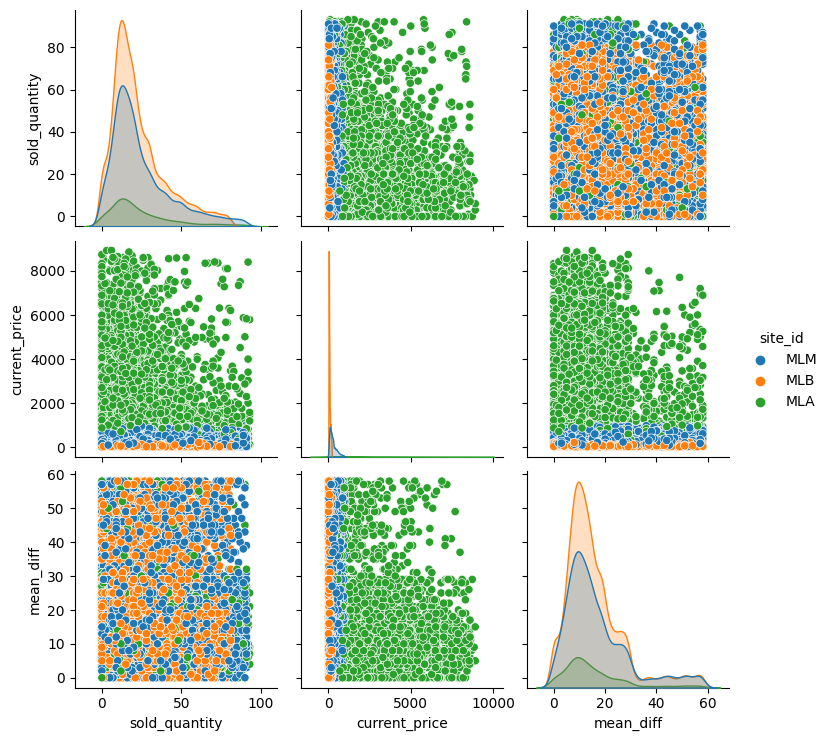

In [19]:
import seaborn as sns

sns.pairplot(sample.drop(columns=["sku"]), hue="site_id")

In [20]:
core_skus[core_skus["currency"] == "MEX"].describe()

,sku,sold_quantity,current_price,mean_diff
count,170591.000000,170591.000000,170591.000000,170591.000000
mean,330568.657637,24.786354,274.473062,16.652127
std,190573.947206,19.438519,209.885288,12.646818
min,2.000000,0.000000,2.400000,0.000000
25%,165626.000000,11.000000,112.540169,8.000000
50%,330697.000000,19.000000,209.779322,13.000000
75%,495328.000000,33.000000,385.000000,22.000000
max,660915.000000,91.000000,974.000000,58.000000


In [21]:
core_skus[core_skus["currency"] == "ARG"].describe()

,sku,sold_quantity,current_price,mean_diff
count,37528.000000,37528.000000,37528.000000,37528.000000
mean,330352.364075,24.486810,2224.283997,15.072746
std,190861.437429,20.306047,2018.214791,11.989311
min,18.000000,0.000000,8.000000,0.000000
25%,165543.750000,11.000000,701.038136,7.000000
50%,329391.000000,18.000000,1519.313814,12.000000
75%,496698.750000,33.000000,3287.856780,19.000000
max,660887.000000,93.000000,8951.271186,58.000000


In [22]:
core_skus[core_skus["currency"] == "REA"].describe()

,sku,sold_quantity,current_price,mean_diff
count,225411.000000,225411.000000,225411.000000,225411.000000
mean,330440.863174,23.056803,65.156404,15.686608
std,190855.696060,17.279659,46.842232,11.584605
min,0.000000,0.000000,0.890000,0.000000
25%,165376.000000,11.000000,29.990000,8.000000
50%,330485.000000,18.000000,49.748475,13.000000
75%,495529.500000,30.000000,85.524068,19.000000
max,660914.000000,81.000000,211.471356,58.000000


Although the min and max values of sold quantity are similar for the three markets, the min and max values for current prince are quite different. This leads to scale with different scalers for each country.

### scaling

In [29]:
mex_core_skus

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id
2,2,1,250.304348,MEX,premium,drop_off,paid_shipping,0,MLM
3,3,8,399.000000,MEX,premium,fulfillment,free_shipping,14,MLM
5,5,15,571.748814,MEX,premium,fulfillment,free_shipping,25,MLM
6,6,29,490.915254,MEX,classic,fulfillment,free_shipping,22,MLM
9,9,18,224.423729,MEX,premium,fulfillment,free_shipping,51,MLM
...,...,...,...,...,...,...,...,...,...
535799,660889,18,189.381356,MEX,premium,fulfillment,paid_shipping,58,MLM
535800,660890,20,35.000000,MEX,premium,fulfillment,paid_shipping,18,MLM
535818,660910,12,487.079322,MEX,premium,fulfillment,free_shipping,15,MLM
535820,660912,14,99.000000,MEX,classic,fulfillment,paid_shipping,11,MLM


In [38]:
from sklearn.preprocessing import MinMaxScaler

mex_scaler = MinMaxScaler()
mex_scaled = mex_scaler.fit_transform(mex_core_skus[["sold_quantity", "current_price"]])
mex_core_skus_scaled = mex_core_skus.drop(columns=["sold_quantity", "current_price"])
mex_core_skus_scaled["sold_quantity"] = mex_scaled[:, 0]
mex_core_skus_scaled["current_price"] = mex_scaled[:, 1]

arg_scaler = MinMaxScaler()
arg_scaled = arg_scaler.fit_transform(arg_core_skus[["sold_quantity", "current_price"]])
arg_core_skus_scaled = arg_core_skus.drop(columns=["sold_quantity", "current_price"])
arg_core_skus_scaled["sold_quantity"] = arg_scaled[:, 0]
arg_core_skus_scaled["current_price"] = arg_scaled[:, 1]

bra_scaler = MinMaxScaler()
bra_scaled = bra_scaler.fit_transform(bra_core_skus[["sold_quantity", "current_price"]])
bra_core_skus_scaled = bra_core_skus.drop(columns=["sold_quantity", "current_price"])
bra_core_skus_scaled["sold_quantity"] = bra_scaled[:, 0]
bra_core_skus_scaled["current_price"] = bra_scaled[:, 1]

In [39]:
core_skus_scaled = pd.concat([mex_core_skus_scaled, arg_core_skus_scaled, bra_core_skus_scaled])

In [40]:
core_skus_scaled

,sku,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,sold_quantity,current_price
2,2,MEX,premium,drop_off,paid_shipping,0,MLM,0.010989,0.255151
3,3,MEX,premium,fulfillment,free_shipping,14,MLM,0.087912,0.408193
5,5,MEX,premium,fulfillment,free_shipping,25,MLM,0.164835,0.585991
6,6,MEX,classic,fulfillment,free_shipping,22,MLM,0.318681,0.502795
9,9,MEX,premium,fulfillment,free_shipping,51,MLM,0.197802,0.228514
...,...,...,...,...,...,...,...,...,...
535816,660907,REA,premium,fulfillment,paid_shipping,13,MLB,0.111111,0.115741
535817,660908,REA,premium,fulfillment,paid_shipping,12,MLB,0.925926,0.130052
535819,660911,REA,classic,fulfillment,paid_shipping,7,MLB,0.234568,0.056576
535821,660913,REA,premium,fulfillment,free_shipping,16,MLB,0.123457,0.666920


In [41]:
enconded_core_skus = pd.get_dummies(
    core_skus_scaled,
    columns=["currency", "listing_type", "shipping_logistic_type", "shipping_payment", "site_id"]
).drop(columns=["listing_type_classic", "shipping_payment_free_shipping"]) #We drop this columns cause their information is redundant since they're binay categories.

In [42]:
enconded_core_skus

,sku,mean_diff,sold_quantity,current_price,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,site_id_MLA,site_id_MLB,site_id_MLM
2,2,0,0.010989,0.255151,0,1,0,1,0,1,0,1,0,0,1
3,3,14,0.087912,0.408193,0,1,0,1,0,0,1,0,0,0,1
5,5,25,0.164835,0.585991,0,1,0,1,0,0,1,0,0,0,1
6,6,22,0.318681,0.502795,0,1,0,0,0,0,1,0,0,0,1
9,9,51,0.197802,0.228514,0,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535816,660907,13,0.111111,0.115741,0,0,1,1,0,0,1,1,0,1,0
535817,660908,12,0.925926,0.130052,0,0,1,1,0,0,1,1,0,1,0
535819,660911,7,0.234568,0.056576,0,0,1,0,0,0,1,1,0,1,0
535821,660913,16,0.123457,0.666920,0,0,1,1,0,0,1,0,0,1,0


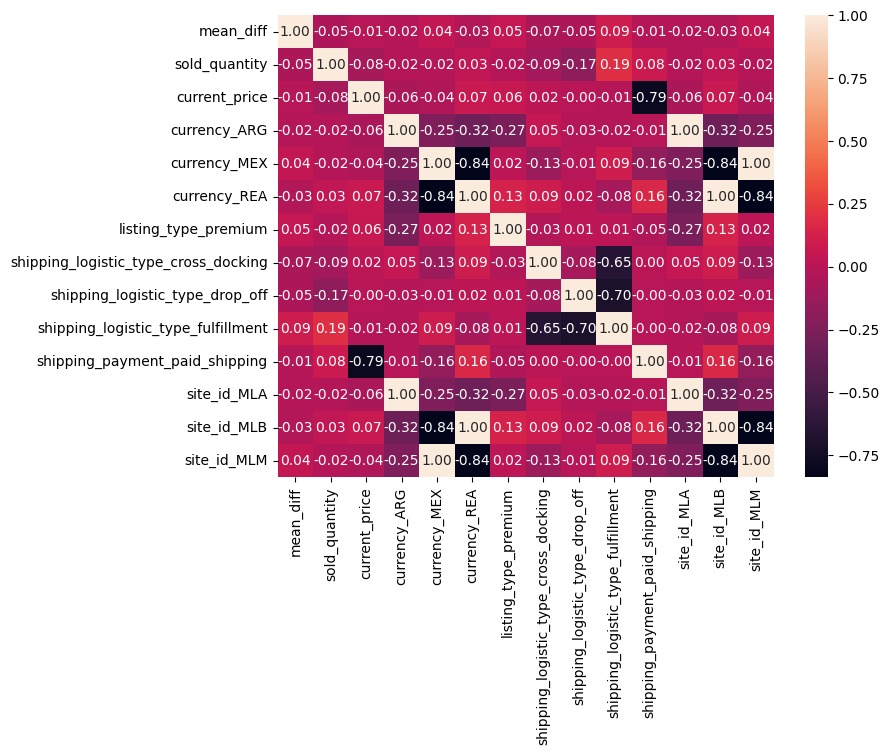

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(enconded_core_skus.drop(columns=["sku"]).corr(), annot=True, fmt=".2f")

First, note that site_id and currency represent the same information, so we'll rule out site_id.
On the other hand, our target variable (mean_diff) is not significantly correlated with any of the inputs. This already tells us that our predictions are not goint to be the best and the algothym will assign very similar probability distributions no matter the product.

In [ ]:
enconded_core_skus = enconded_core_skus.drop(columns=["site_id_MLA", "site_id_MLB", "site_id_MLM"])

In [45]:
#we're interested in the probabilities of an item being out of stock before 30 days since published.
enconded_core_skus["mean_diff"] = enconded_core_skus["mean_diff"].apply(lambda x: x if x <= 29 else -1)
enconded_core_skus = enconded_core_skus[enconded_core_skus["mean_diff"] != -1]

<Axes: xlabel='index'>

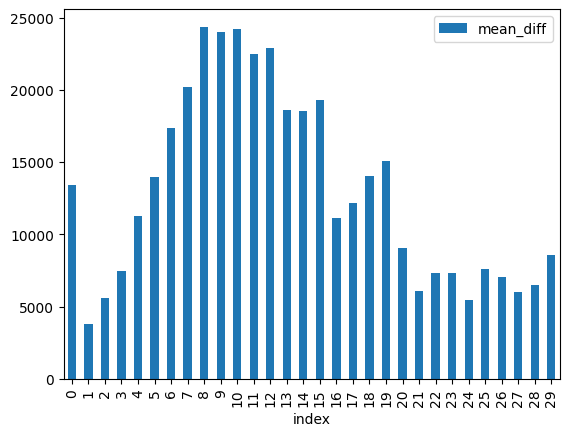

In [46]:
enconded_core_skus["mean_diff"].value_counts().reset_index().sort_values("index").plot.bar(x="index", y="mean_diff")

This is the shape we expect the probability distributions to follow no matter the product

In [51]:
core_skus_scaled

,sku,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,sold_quantity,current_price
2,2,MEX,premium,drop_off,paid_shipping,0,MLM,0.010989,0.255151
3,3,MEX,premium,fulfillment,free_shipping,14,MLM,0.087912,0.408193
5,5,MEX,premium,fulfillment,free_shipping,25,MLM,0.164835,0.585991
6,6,MEX,classic,fulfillment,free_shipping,22,MLM,0.318681,0.502795
9,9,MEX,premium,fulfillment,free_shipping,51,MLM,0.197802,0.228514
...,...,...,...,...,...,...,...,...,...
535816,660907,REA,premium,fulfillment,paid_shipping,13,MLB,0.111111,0.115741
535817,660908,REA,premium,fulfillment,paid_shipping,12,MLB,0.925926,0.130052
535819,660911,REA,classic,fulfillment,paid_shipping,7,MLB,0.234568,0.056576
535821,660913,REA,premium,fulfillment,free_shipping,16,MLB,0.123457,0.666920


In [52]:
enconded_core_skus

,sku,mean_diff,sold_quantity,current_price,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping
2,2,0,0.010989,0.255151,0,1,0,1,0,1,0,1
3,3,14,0.087912,0.408193,0,1,0,1,0,0,1,0
5,5,25,0.164835,0.585991,0,1,0,1,0,0,1,0
6,6,22,0.318681,0.502795,0,1,0,0,0,0,1,0
11,12,9,0.362637,0.615068,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
535816,660907,13,0.111111,0.115741,0,0,1,1,0,0,1,1
535817,660908,12,0.925926,0.130052,0,0,1,1,0,0,1,1
535819,660911,7,0.234568,0.056576,0,0,1,0,0,0,1,1
535821,660913,16,0.123457,0.666920,0,0,1,1,0,0,1,0


In [53]:
from sklearn.model_selection import train_test_split

n_sample = 50000
X, y = enconded_core_skus.drop(columns=["sku", "mean_diff"]), enconded_core_skus["mean_diff"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=SEED
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=20180507)

In [56]:
y_pred = rf.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average="weighted"), precision_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")

(0.06941531536139955,
 0.06941531536139955,
 0.06875973514110219,
 0.06905800385753393)

In [58]:
pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

,feature,importance
1,current_price,0.890799
0,sold_quantity,0.102616
5,listing_type_premium,0.002253
9,shipping_payment_paid_shipping,0.001231
8,shipping_logistic_type_fulfillment,0.001072
7,shipping_logistic_type_drop_off,0.000648
6,shipping_logistic_type_cross_docking,0.000373
3,currency_MEX,0.000354
4,currency_REA,0.000338
2,currency_ARG,0.000317


In [59]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    random_state=SEED,
    n_jobs=-1,
    max_iter=1000,
    penalty='l1',
    solver='saga'
)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=20180507, solver='saga')

In [60]:
lr_y_pred = lr.predict(X_test)

In [61]:
accuracy_score(y_test, lr_y_pred), recall_score(y_test, lr_y_pred, average="weighted"), precision_score(y_test, lr_y_pred, average="weighted", zero_division=0), f1_score(y_test, lr_y_pred, average="weighted")

(0.07981226661210292,
 0.07981226661210292,
 0.04019928832396778,
 0.0422353635791297)

In [62]:
#df with feature weights
pd.DataFrame({
    "feature": X.columns,
    "weight": lr.coef_[0]
}).sort_values("weight", ascending=False)

,feature,weight
7,shipping_logistic_type_drop_off,0.293054
2,currency_ARG,0.237569
4,currency_REA,0.000000
6,shipping_logistic_type_cross_docking,0.000000
5,listing_type_premium,-0.072072
9,shipping_payment_paid_shipping,-0.376704
3,currency_MEX,-0.380396
1,current_price,-0.970887
8,shipping_logistic_type_fulfillment,-1.507641
0,sold_quantity,-6.405843


In [63]:
tmp = pd.DataFrame(lr.predict_proba(X_test), columns=lr.classes_)
tmp

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.044155,0.007379,0.012306,0.019978,0.036446,0.058878,0.069910,0.073238,0.077836,0.071163,...,0.017179,0.009648,0.013787,0.011823,0.006889,0.013493,0.010717,0.008962,0.012842,0.016315
1,0.000497,0.003746,0.006246,0.015328,0.048538,0.119174,0.140797,0.128353,0.115744,0.087151,...,0.007295,0.003405,0.007007,0.005418,0.003537,0.004574,0.002365,0.003818,0.004406,0.007661
2,0.003325,0.010059,0.013592,0.018845,0.032022,0.039252,0.048014,0.055312,0.067145,0.066899,...,0.022960,0.015579,0.015249,0.016550,0.016149,0.020084,0.018493,0.014496,0.016992,0.019497
3,0.021946,0.014115,0.019216,0.024008,0.030436,0.031249,0.036345,0.042296,0.054452,0.053832,...,0.025719,0.019041,0.018120,0.019971,0.018522,0.024744,0.021846,0.017596,0.018798,0.024467
4,0.006885,0.009926,0.016088,0.020526,0.032997,0.034437,0.042408,0.048168,0.057648,0.061232,...,0.024039,0.015623,0.021830,0.022973,0.020700,0.023495,0.024486,0.017897,0.021282,0.023520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78191,0.035663,0.009337,0.014968,0.018471,0.022489,0.031464,0.035923,0.043275,0.055444,0.056958,...,0.025746,0.018399,0.021376,0.022113,0.014354,0.020386,0.019111,0.015538,0.022635,0.027222
78192,0.075124,0.012504,0.022642,0.039293,0.048878,0.066955,0.071461,0.074510,0.070007,0.056916,...,0.015640,0.008553,0.013634,0.016054,0.009939,0.013726,0.010582,0.011861,0.010472,0.019356
78193,0.003443,0.010097,0.013645,0.018854,0.031857,0.038668,0.047311,0.054511,0.066427,0.066673,...,0.023118,0.015672,0.015316,0.016748,0.016489,0.020323,0.018997,0.014612,0.017485,0.019555
78194,0.008321,0.011129,0.015663,0.019538,0.031689,0.029449,0.038898,0.045179,0.056157,0.057784,...,0.025612,0.016829,0.020518,0.021006,0.019136,0.025119,0.024530,0.019090,0.017361,0.022552


In [64]:
tmp.idxmax(axis=1).mean(), y_test.mean()

(8.753427285283134, 12.868369226047369)

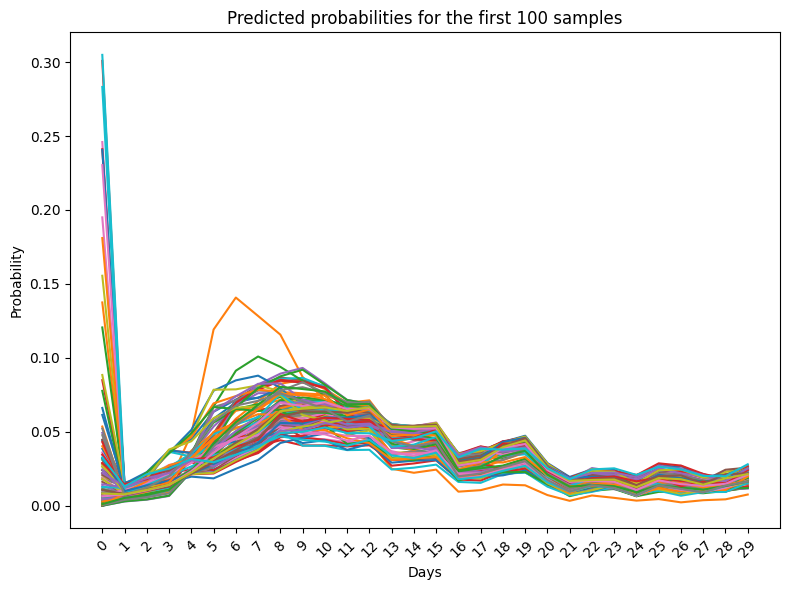

In [66]:
plt.figure(figsize=(8, 6))
for i in range(100):
    plt.plot(tmp.columns, tmp.iloc[i], label=f"sample_{i}")

plt.title("Predicted probabilities for the first 100 samples")
plt.xlabel("Days")
plt.ylabel("Probability")
plt.xticks(ticks=range(len(tmp.columns)), labels=tmp.columns, rotation=45)
plt.tight_layout()